In [2]:
import streamlit as st
import pandas as pd
import numpy as np
import yaml
import pyodbc
from market_growth_analysis.etl.stagging import *
import pandas as pd
import numpy as np
import pyodbc
import sqlalchemy
from sqlalchemy import create_engine
import sys
import pandas as pd
import matplotlib.pyplot as plt

# sys.path.append('../conf') 
# Load the YAML file
with open('../../conf/global.yml', 'r') as f:
    columns = yaml.safe_load(f)

# Load the YAML file
with open('../../conf/local.yml', 'r') as f:
    credentials = yaml.safe_load(f)


# Get credentials
driver = credentials['warehouse_db']['driver']
server = credentials['warehouse_db']['server']
database = credentials['warehouse_db']['database']
trusted = credentials['warehouse_db']['trusted_connection']
user = credentials['warehouse_db']['user']
password = credentials['warehouse_db']['password']

# Create connection db
conn = pyodbc.connect('Driver={SQL Server};'
                      f'Server={server};'
                      f'Database={database};'
                      'Trusted_Connection=yes;')
cursor = conn.cursor()

In [3]:
# Get data
join_tables_query = '''
select *
from DIM_COMPANY dim
join FACT_BALANCE_SHEET bs on bs.ticker = dim.ticker
join FACT_CASH_FLOW_STATEMENT cfs on cfs.PK = bs.PK
join FACT_INCOME_STATEMENT fis on fis.PK = bs.PK
join FACT_PRICES fp on fp.PK = bs.PK
join FACT_RATIOS fr on fr.PK = bs.PK
'''
data = pd.read_sql(join_tables_query, conn)
# drop duplicated columns
data = data.T.drop_duplicates().T
data['Date'] = pd.to_datetime(data['Date'], format="%Y/%m/%d").dt.strftime("%Y/%m/%d")


C:\Users\germa\AppData\Local\Temp/ipykernel_12968/764186177.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(join_tables_query, conn)


In [4]:
data.columns

Index(['ticker', 'company_full_name', 'country', 'industry', 'sector', 'PK',
       'Date', 'Cash On Hand', 'Receivables', 'Inventory', 'Pre-Paid Expenses',
       'Other Current Assets', 'Total Current Assets',
       'Property, Plant, And Equipment', 'Long-Term Investments',
       'Goodwill And Intangible Assets', 'Other Long-Term Assets',
       'Total Long-Term Assets', 'Total Assets', 'Total Current Liabilities',
       'Long Term Debt', 'Other Non-Current Liabilities',
       'Total Long Term Liabilities', 'Total Liabilities', 'Common Stock Net',
       'Retained Earnings (Accumulated Deficit)', 'Comprehensive Income',
       'Other Share Holders Equity', 'Share Holder Equity',
       'Total Liabilities And Share Holders Equity', 'Net Income/Loss',
       'Total Depreciation And Amortization - Cash Flow',
       'Other Non-Cash Items', 'Total Non-Cash Items',
       'Change In Accounts Receivable', 'Change In Inventories',
       'Change In Accounts Payable', 'Change In Assets/L

In [5]:
data['country'].value_counts()

United States           39989
Canada                   1557
China                    1229
Israel                    753
United Kingdom            709
Bermuda                   443
Ireland                   354
Brazil                    350
Netherlands               194
Hong Kong, SAR China      193
Switzerland               189
Greece                    189
Argentina                 178
Germany                   150
Mexico                    142
South Korea               142
Japan                     129
Singapore                 127
India                     123
Australia                 119
Luxembourg                117
Taiwan                    117
France                    115
Cayman Islands             94
South Africa               94
Chile                      86
Colombia                   60
Spain                      56
Belgium                    54
Peru                       53
Sweden                     53
Denmark                    45
Italy                      42
Panama    

In [6]:
data['industry'].value_counts()

Medical - Biomedical and Genetics        3573
Medical - Drug Manufacturing             1682
Technology Services                      1232
Banks - Northeast                        1199
REIT - Other Equity Trusts               1165
                                         ... 
Nanotechnology Equipment and Services      11
Electronics - Military Systems             11
Retail - Mail Order & Direct                9
Printing & Trade Machinery                  8
Periodical Publishing                       2
Name: industry, Length: 252, dtype: int64

In [7]:
columns_to_study = columns['columns_prices'] + columns['columns_ratios'] + columns['column_id']

In [8]:
industry = 'Technology Services'

data_filtered_industry = data[(data['industry'] == industry)&(data['country'] == 'United States')]

In [64]:
len(data_filtered_industry['ticker'].unique())

170

In [9]:
data_to_study = data_filtered_industry[columns_to_study]

In [10]:
data_to_study = data_to_study.dropna(subset='Growth +5')

In [11]:
data_to_study_filled = data_to_study.fillna(value=0)

In [12]:
data_to_study_filled.columns

Index(['longevity', 'Close', 'Volume', 'Growth -1', 'Growth +1', 'Growth +5',
       'Growth -10', 'Growth -5', 'Enterprise Value (EV)', 'EV / Revenue',
       'EV / EBITDA', 'EV / EBIT', 'EV / Invested Capital',
       'Free Cash Flow (FCF)', 'EV / Free Cash Flow', 'P/E', 'P/S', 'P/CF',
       'PK', 'ticker', 'Date'],
      dtype='object')

In [13]:
columns_to_drop = ['Growth +1', 
                #    'Date', 
                #    'ticker', 
                   'Close', 
                   'Volume', 
                   'longevity', 
                   'Enterprise Value (EV)', 
                   'Free Cash Flow (FCF)', 
                   'EV / EBITDA', 
                   'Growth -5', 
                   'Growth -1', 
                   'Growth -10',
                   'EV / Free Cash Flow',
                   'EV / Invested Capital'
                   ]
data_to_study_filled_drop = data_to_study_filled.drop(columns=columns_to_drop)
data_to_study_filled_drop = data_to_study_filled_drop.set_index(keys='PK')

In [14]:
data_to_study_filled_drop['Growth +5']*100

PK
1954      46.266470
1955     -16.789299
1949      95.422036
1952      72.173905
18165     38.038987
            ...    
38780    -15.602842
8213     150.387606
27751    -74.628879
26297    102.499998
8212      71.276598
Name: Growth +5, Length: 334, dtype: float64

In [15]:
(data_to_study_filled_drop['Growth +5']*100).describe()

count     334.000000
mean      110.025355
std       440.677658
min       -99.999800
25%       -56.975394
50%        -0.431504
75%        90.979180
max      3649.999944
Name: Growth +5, dtype: float64

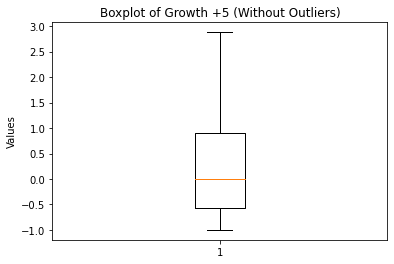

In [16]:
import matplotlib.pyplot as plt

# Assuming data_to_study_filled_drop is your DataFrame
plt.boxplot(data_to_study_filled_drop['Growth +5'], showfliers=False)
plt.title('Boxplot of Growth +5 (Without Outliers)')
plt.ylabel('Values')
plt.show()


In [41]:
# data_to_study_filled_drop['target'] = data_to_study_filled_drop['Growth +5'] > 0
# data_to_study_filled_drop['target'] = data_to_study_filled_drop['target'].astype(int)

import pandas as pd
import numpy as np

# Assuming you have a DataFrame named data_to_study_final
# data_to_study_filled_drop['target'] = np.where(data_to_study_filled_drop['Growth +5'] < 0, 0, 
#                         np.where(data_to_study_filled_drop['Growth +5'] <= data_to_study_filled_drop['Growth +5'].quantile(0.9), 1, 2))

data_to_study_filled_drop['target'] = np.where(data_to_study_filled_drop['Growth +5'] < 0, 0, 1)

# data_to_study_filled_drop['target'] = np.where(data_to_study_filled_drop['Growth +5'] < 0, 0, 
#                                     np.where(data_to_study_filled_drop['Growth +5'] < 2.5, 1, 2))

num_classes = len(data_to_study_filled_drop['target'].unique())
num_classes

2

In [42]:
data_to_study_filled_drop['target'].value_counts()

1    167
0    167
Name: target, dtype: int64

In [43]:
data_to_study_filled_drop['Growth +5'].quantile(0.9)

2.8773593254170655

In [44]:
data_to_study_final = data_to_study_filled_drop.drop(columns='Growth +5')

In [45]:
data_to_study_final.shape

(334, 8)

In [46]:
data_to_study_final['target'].value_counts()

1    167
0    167
Name: target, dtype: int64

# Create LSTM Model

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

## Prepare Data

In [49]:
# Load your financial data into a DataFrame (replace 'your_data.csv' with your dataset)
df = data_to_study_final.copy()

# Define the sequence length and other hyperparameters
n_steps = 5 # years to study prior
# n_features = len(df.columns) - 1  # Replace with the number of feature columns in your dataset
num_companies = len(df['ticker'].unique())  # Assuming you have a 'ticker' column

# Use LabelEncoder to convert 'ticker' values to numerical labels
label_encoder = LabelEncoder()
df['ticker'] = label_encoder.fit_transform(df['ticker'])

# Prepare an empty list to store sequences for all companies
all_sequences = []
all_targets = []  # To store the corresponding target values
all_sequences_train = []
all_sequences_test = []
all_targets_train = []  # To store the corresponding target values
all_targets_test = []  # To store the corresponding target values

# Define the percentage of data to allocate for testing
test_size = 0.2

# Iterate through unique company labels
for label in df['ticker'].unique():
    # Filter data for the current company label
    company_data = df[df['ticker'] == label]

    # Sort data by date
    company_data = company_data.sort_values(by='Date').drop(columns=['Date', 'ticker'])
    n_features = len(company_data.columns) - 1 
    # Create sequences for the current company
    sequences = []
    targets = []  # To store the corresponding target values
    sequences_train = []
    sequences_test = []
    targets_train = []
    targets_test = []
    for i in range(len(company_data) - n_steps + 1):
        sequence = company_data.iloc[i:i + n_steps, 0:n_features].values  # Adjust column indices
        target = company_data.iloc[i + n_steps - 1, n_features]  # Assuming the target column is the last one
        sequences.append(sequence)
        targets.append(target)

    # Calculate the index to split the data
    split_index = int(len(targets) * (1 - test_size))

    # Split the data into training and testing sets
    sequences_train = sequences[:split_index]
    sequences_test = sequences[split_index:]
    targets_train = targets[:split_index]
    targets_test = targets[split_index:]

    # Append sequences and corresponding targets to the lists
    all_sequences.extend(sequences)
    all_targets.extend(targets)
    # Append sequences and corresponding targets to the lists
    all_sequences_train.extend(sequences_train)
    all_sequences_test.extend(sequences_test)
    all_targets_train.extend(targets_train)
    all_targets_test.extend(targets_test)

# Split train test

In [50]:
from sklearn.model_selection import train_test_split

# Define the percentage of data to allocate for testing
test_size = 0.2

# Calculate the index to split the data
split_index = int(len(all_targets) * (1 - test_size))

# Split the data into training and testing sets
X_train, X_test = all_sequences_train, all_sequences_test
y_train, y_test = all_targets_train, all_targets_test

## Create Model

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the LSTM model for classification
class LSTMClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassificationModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

# hyperparameters

In [52]:
# Define hyperparameters
input_size = len(all_sequences[0][0])  # Number of features in each sequence
hidden_size = 32
num_layers = 1
output_size = num_classes  # Three classes for classification (0, 1, 2)

# Create the classification model
classification_model = LSTMClassificationModel(input_size, hidden_size, num_layers, output_size)

# Define the loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(classification_model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.int)

# Train

In [53]:
# Train the classification model
num_epochs = 200
best_precision = 0.0  # Initialize the best precision for class 1
best_model = None

for epoch in range(num_epochs):
    outputs = classification_model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # Evaluate precision on class 1 (target = 1)
    classification_model.eval()
    with torch.no_grad():
        test_outputs = classification_model(X_test)

        # Apply softmax to obtain class probabilities
        class_probs = torch.nn.functional.softmax(test_outputs, dim=1)
        _, predicted = torch.max(test_outputs, 1)  # Get the predicted class labels

        # Convert the predictions and class probabilities to numpy arrays
        y_pred = predicted.cpu().numpy()
        class_probs = class_probs.cpu().numpy()

    # Calculate precision for class 1
    precision_class_1 = precision_score(y_test, y_pred, labels=[1], average='macro')

    # Check if precision for class 1 is better than the best seen so far
    if precision_class_1 > best_precision:
        best_precision = precision_class_1
        best_model = classification_model.state_dict()
        print(f'Improved precision for class 1: {best_precision:.4f}')

# Use the best model with the highest precision for class 1
classification_model.load_state_dict(best_model)

Improved precision for class 1: 0.6471
Improved precision for class 1: 0.6667
Epoch [10/200], Loss: 0.6287
Improved precision for class 1: 0.6842
Epoch [20/200], Loss: 0.5884
Epoch [30/200], Loss: 0.5469
Epoch [40/200], Loss: 0.5027
Epoch [50/200], Loss: 0.4520
Epoch [60/200], Loss: 0.4012
Improved precision for class 1: 0.7000
Epoch [70/200], Loss: 0.3501
Improved precision for class 1: 0.7222
Improved precision for class 1: 0.7647
Epoch [80/200], Loss: 0.3018
Epoch [90/200], Loss: 0.2565
Epoch [100/200], Loss: 0.2184
Epoch [110/200], Loss: 0.1841
Epoch [120/200], Loss: 0.1540
Epoch [130/200], Loss: 0.1280
Epoch [140/200], Loss: 0.1064
Epoch [150/200], Loss: 0.0887
Epoch [160/200], Loss: 0.0736
Epoch [170/200], Loss: 0.0619
Epoch [180/200], Loss: 0.0529
Epoch [190/200], Loss: 0.0459
Epoch [200/200], Loss: 0.0400


<All keys matched successfully>

# Evaluate

In [54]:
# Evaluate the classification model on the test data
classification_model.eval()
with torch.no_grad():
    test_outputs = classification_model(X_test)
    _, predicted = torch.max(test_outputs, 1)  # Get the predicted class labels

# Convert the predictions and true labels to numpy arrays
y_pred = predicted.cpu().numpy()
y_true = y_test.numpy()


In [55]:
# Filter class_probs for examples where y_pred is equal to 1
indices_class_1 = (y_pred == 1)  # Get indices where y_pred is equal to 1
class_probs_class_1 = class_probs[indices_class_1]  # Filter class_probs

# Create y_pred_mod based on class_probs_class_1
y_pred_mod = np.zeros_like(y_pred)
y_pred_mod[indices_class_1] = (class_probs_class_1[:, 1] > 0.9).astype(int)

# Metrics

In [56]:
def metrics_form(y_true, y_pred):    
    # Calculate classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    confusion = confusion_matrix(y_true, y_pred)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print('Confusion Matrix:')
    print(confusion)

In [57]:
# Calculate classification metrics
metrics_form(y_true, y_pred)

Accuracy: 0.7250
Precision: 0.7298
Recall: 0.7281
F1-score: 0.7248
Confusion Matrix:
[[14  7]
 [ 4 15]]


In [58]:
# Calculate classification metrics
metrics_form(y_true, y_pred_mod)

Accuracy: 0.7750
Precision: 0.7940
Recall: 0.7682
F1-score: 0.7679
Confusion Matrix:
[[19  2]
 [ 7 12]]


In [61]:
# Calculate precision for class 1
precision_class_1 = precision_score(y_true, y_pred_mod, labels=[1], average='macro')
precision_class_1

0.8571428571428571

In [60]:
# Calculate precision for class 1
recall_class_1 = recall_score(y_true, y_pred_mod, labels=[1], average='macro')
recall_class_1

0.631578947368421